# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Wei JIANG, Minghui SHI, Costanza VOLPINI

**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# Additional imports
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage.measure as measure

from skimage.transform import rotate, AffineTransform, warp
import random
import cv2
import math
from numpy.linalg import inv

from scipy.interpolate import Rbf
from scipy.ndimage import morphology

from skimage.measure import regionprops, label
from matplotlib.patches import Ellipse

from sklearn import decomposition

In [159]:
# Helper functions
# Convert contour into complex signals
def convert_signal(contour):
#     contour -= contour.mean() # do we demean the data?
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,1] + 1j*contour[:,0] 
    return output

# Find outer contour and convert
def contour_fourier(images):
    contour_out = []
    
    for im in images:
        im = ndimage.binary_fill_holes(im)
        im[im>0] =255
        contours = measure.find_contours(im, 0)
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_out.append(convert_signal(contour))
    return np.array(contour_out)



# Affine transform Helper functions: convertImg, affineTransform

# Convert image coordinates to matrix
def convertImg(img):   
    N = img.shape[0]
    # zero padding
    if N%2 == 0:
        img = np.pad(img, ((5,6),(5,6)), mode='constant',constant_values=0)
        N+=11
    else:
        img = np.pad(img, ((5,5),(5,5)), mode='constant',constant_values=0)
        N+=10
    x = np.arange(-(N//2), N//2+1)
    y = np.arange(-(N//2), N//2+1)


    xx, yy = np.meshgrid(x, y)
    out = []
    out.append(xx.reshape([1,-1]))
    out.append(yy.reshape([1,-1]))
    out.append(np.ones(yy.reshape([1,-1]).shape))
    out = np.array(out).squeeze()
    return xx,yy,img,out

def affineTransform(img, rotation, scaling, translation):
    xx,yy,img,imgvec = convertImg(img)
    # rotation
    if rotation:
        theta =  random.uniform(-np.pi, np.pi)
        a0 = 0
        a1 = math.cos(theta)
        a2 = math.sin(theta)
        b0 = 0
        b1 = -math.sin(theta)
        b2 = math.cos(theta)
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    # scaling
    if scaling:
        s =  random.uniform(0.8, 1.2)
        a0 = 0
        a1 = 1/s
        a2 = 0
        b0 = 0
        b1 = 0
        b2 = 1/s 
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    # translation
    if translation:
        tx =  random.randint(-2, 2)
        ty =  random.randint(-2, 2)
        a0 = -tx
        a1 = 1
        a2 = 0
        b0 = -ty
        b1 = 0
        b2 = 1        
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    xt = imgvec[0,:]
    yt = imgvec[1,:]
    
    # interpolation
    rbf = Rbf(xx, yy, img, epsilon=2)
    imgt = rbf(xt, yt)
    
    # normalize and threshold
    imgt = imgt- imgt.min()
    imgt = imgt/ (imgt.max()-imgt.min())
    t = 0.4
    imgt[imgt>= t] = 1
    imgt[imgt<t] = 0
    imgt = imgt*255
    
    return imgt.reshape(xx.shape)


# Plot images with contours
def plotImagContour(axes, contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
    for ax0, ax1, contour0, contour1,im0, im1, nm0, nm1 in zip(axes[0], axes[1], contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
        ax0.imshow(im0)
        ax0.step(np.real(contour0), np.imag(contour0), linewidth=2, c='r')
        ax0.axis('off')
        ax0.set_title(nm0)

        ax1.imshow(im1)
        ax1.step(np.real(contour1), np.imag(contour1), linewidth=2, c='r')
        ax1.axis('off')
        ax1.set_title(nm1)
        
        
# Skeletonize
def skeletonize(im):
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    size = np.size(im)
    skel = np.zeros(im.shape, np.uint8)
    while True:
        eroded = cv2.erode(im, element)
        im = eroded.copy()
        if cv2.countNonZero(im)==0:
            break
        open = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(eroded, open)
        skel = cv2.bitwise_or(skel,temp)
    skel[skel>0]=1
    return skel

# Fourier Descriptor

def get_fourier_discriptor(images_1, images_2, f1, f2, f_div, plot = False):
    
    # Contour detection
    contourf_0 = contour_fourier(images_1)
    contourf_1 = contour_fourier(images_2)


    FD_0 = np.zeros((10,2))
    FD_1 = np.zeros((10,2))

    for i in range(len(images_1)):

        fft0 = np.fft.fft(contourf_0[i])#,n = N)
        fft1 = np.fft.fft(contourf_1[i])#, n = N)


        # normalization
        if f_div == -1:
            FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])
                   
        else:
            FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
            FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[f_div])
    if plot:
        zeros = plt.scatter(FD_0[:,0], FD_0[:,1]) 
        ones = plt.scatter(FD_1[:,0], FD_1[:,1])
#         plt.legend((zeros,ones),("0","1"))
        plt.show()
    return FD_0, FD_1

# Chain code calculation
# Code taken from pseudocode: http://www.cs.unca.edu/~reiser/imaging/chaincode.html 
def chain_code(im):
    '''
    Directions  0 1 2    Change in    -1  0  1   Change in    -1 -1 -1
               7 x 3    x-dimension  -1  0  1   y-dimension   0  0  0
               6 5 4                 -1  0  1                 1  1  1
    '''
    chain = []
    contour = [] #just for debug
    
    im = im.copy()
    
    # Find the first pixel on the boundary of the object. 
    for r in range(0, im.shape[0]):
        for c in range(0, im.shape[1]):
            if im[r][c] == 255:
                start_r = r
                start_c = c
                break
    
    # chain code
    directions = [0, 1, 2, 7, 3, 6, 5, 4]
    change_y = [-1, -1, -1, 0, 0, 1, 1, 1]
    change_x = [-1, 0, 1, -1, 1, -1, 0, 1]
    
    r = start_r
    c = start_c
    
    for index, d in enumerate(directions):
        if im[start_r + change_y[index], start_c + change_x[index]] == 255:
            r = start_r + change_y[index]
            c = start_c + change_x[index]
            contour.append((r, c))
            chain.append(d)
            break

    while (r != start_r) or (c != start_c):
        # decide where start
        b_direction = (d + 5) % 8
        dir1 = range(b_direction, 8)
        dir2 = range(0, b_direction)
        directions_ext = list(dir1) + list(dir2)
        for d in directions_ext:
            index = directions.index(d)
            if im[r + change_y[index], c + change_x[index]] == 255:
                r = r + change_y[index]
                c = c + change_x[index] 
                contour.append((r, c))
                chain.append(d)
                break
    
    plt.imshow(im)
    plt.plot([i[1] for i in contour], [i[0] for i in contour])
    plt.show()
    return chain

# Edition distance calculation
# inspired by pseudo code on wikipedia: https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm
def editDistance(c1, c2):
    m = len(c1)
    n = len(c2)
    D = np.zeros([m,n])
    D[0,:] = range(n)
    D[:,0] = range(m)
    for i in range(1,m):
        for j in range(1,n):
            if c1[i] == c2[j]:
                D[i,j] = D[i-1, j-1]
            else:
                D[i,j]= np.min([D[i-1,j]+1, D[i,j-1]+1, D[i-1,j-1] + 1])
    return D[m-1,n-1]

# Elongation (Eclipse fitted) calculation and plot
def elongation_plot(img):
    label_img = label(img)
    [props] = regionprops(label_img)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    (y0, x0) = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    ellipse = Ellipse(xy=(x0, y0), width=props.minor_axis_length, height=props.major_axis_length, angle = 90 - orientation/3.14*180,
                        edgecolor='b', fc='None', lw=2)
    ax.add_patch(ellipse)
    plt.show()

# Rotate image
def rotate(img, theta):
    xx,yy,img,imgvec = convertImg(img)
    # rotation
    if rotation:
        a0 = 0
        a1 = math.cos(theta)
        a2 = math.sin(theta)
        b0 = 0
        b1 = -math.sin(theta)
        b2 = math.cos(theta)
        operator = np.array([[a1, a2, a0],[b1, b2, b0], [0, 0, 1]])
        imgvec = inv(operator) @ imgvec
    xt = imgvec[0,:]
    yt = imgvec[1,:]
    
    # interpolation
    rbf = Rbf(xx, yy, img, epsilon=2)
    imgt = rbf(xt, yt)   
    # normalize and threshold
    imgt = imgt- imgt.min()
    imgt = imgt/ (imgt.max()-imgt.min())
    t = 0.4
    imgt[imgt>= t] = 1
    imgt[imgt<t] = 0
    imgt = imgt*255 
    return imgt.reshape(xx.shape)
    

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

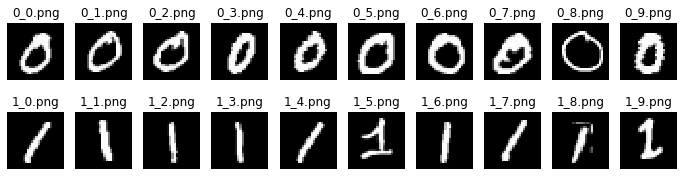

In [8]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)


### 1.2 Fourier descriptors
Add your implementation and discussion

### Invariances rotation, translation, scaling

In [9]:
zeros_im[zeros_im>0] = 255
ones_im[ones_im>0] = 255

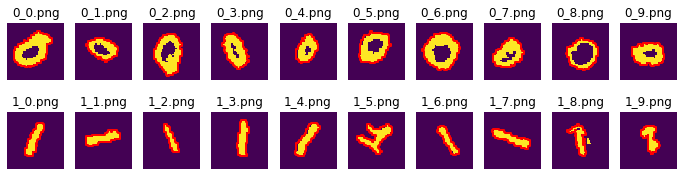

In [12]:
# Apply affine transformations with boolean flags and plot the results
rotation = True
scaling = True
translation = True

im_af0 = []
im_af1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform(img0, rotation, scaling, translation)
    img1 = affineTransform(img1, rotation, scaling, translation)
    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)


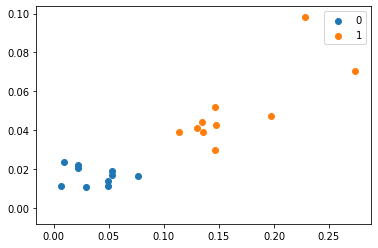

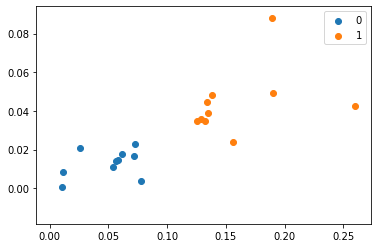

In [15]:
# Fourier descriptors of original images and transformed images
f1 = 3
f2 = 5
f_div = 1
FD_0_orig, FD_1_orig = get_fourier_discriptor(zeros_im, ones_im, f1, f2, f_div)
FD_0, FD_1 = get_fourier_discriptor(im_af0, im_af1, f1, f2, f_div)


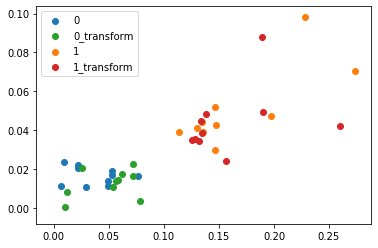

In [16]:
# Superimposed plot of original and transformed to test invariances
zeros = plt.scatter(FD_0_orig[:,0],FD_0_orig[:,1]) 
ones = plt.scatter(FD_1_orig[:,0],FD_1_orig[:,1])
zeros_tf = plt.scatter(FD_0[:,0],FD_0[:,1]) 
ones_tf = plt.scatter(FD_1[:,0],FD_1[:,1])
plt.legend((zeros,zeros_tf,ones,ones_tf), ("0","0_transform","1", "1_transform"))

### 1.3 Additional method(s)
Add your implementation and discussion
### TODO: Do we still want to apply these two methods below??

### Compacity 

### Moments 


### Freeman Code


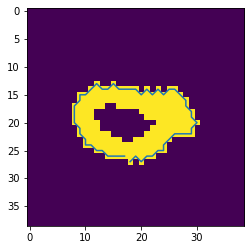

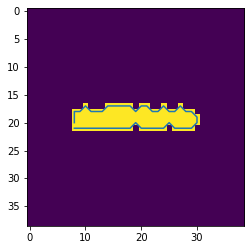

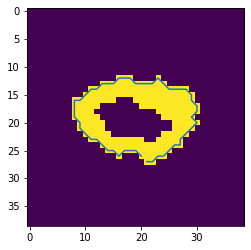

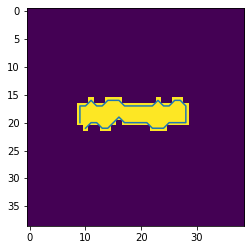

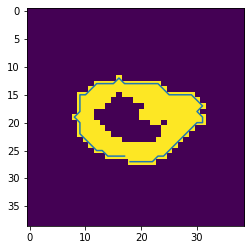

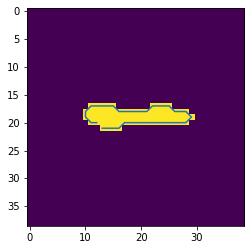

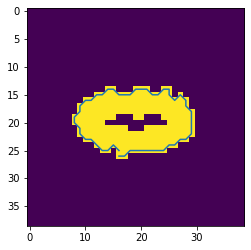

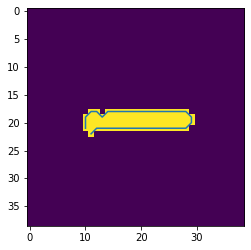

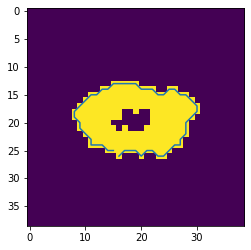

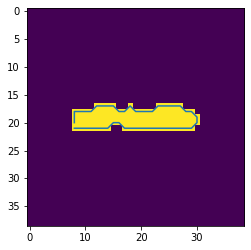

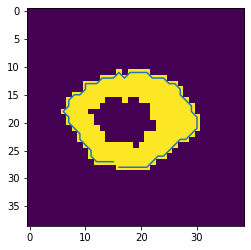

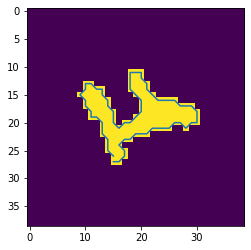

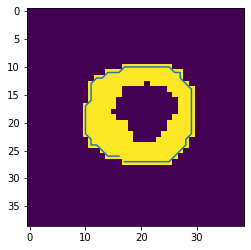

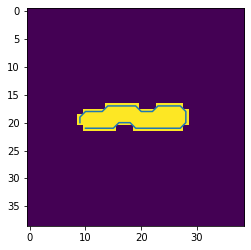

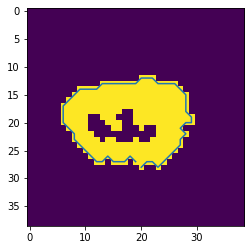

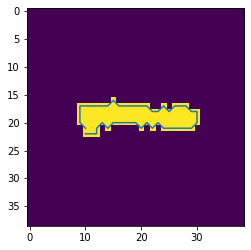

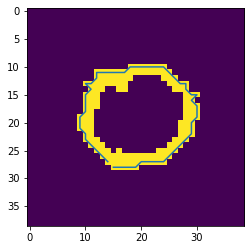

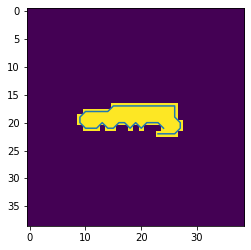

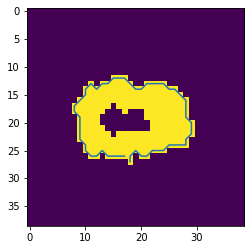

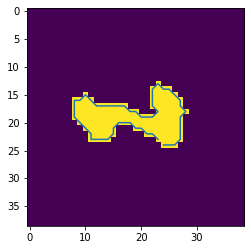

In [166]:
# Calculate chain codes for images and plot results

chain_zeros = []
chain_ones = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    # Preprocess images to remove small deteched object pixels that could confuse the chain code calculation function
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    img1 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, element)
    img2 = cv2.morphologyEx(img2, cv2.MORPH_OPEN, element)
    
    # Aligh orientation
    [props0] = regionprops(img0)
    [props1] = regionprops(img1)
    img0 = rotate(img0, -props0.orientation)
    img1 = rotate(img1, -props1.orientation)
    # Calculate chain code
    chain_zeros.append(chain_code(img0))
    chain_ones.append(chain_code(img1))

# Combine all chain codes
chains = []
chains.append(chain_zeros)
chains.append(chain_ones)
chains = np.array(chains).reshape(1,-1)

In [167]:
# Calculate chain code edition distances
ED0 = []
ED1 = []
L0 = []
L1 = []
D0 = []
D1 =[]
for c0, c1 in zip(chain_zeros, chain_ones):
    L0.append(len(c0))
    L1.append(len(c1))
    for cref in chains:
        # mean edition distance between each pair
        ED0.append(editDistance(cref, c0))
        ED1.append(editDistance(cref, c1))
        
    D0.append(np.mean(ED0))
    D1.append(np.mean(ED1))

D0 = np.array(D0)
D1 = np.array(D1)

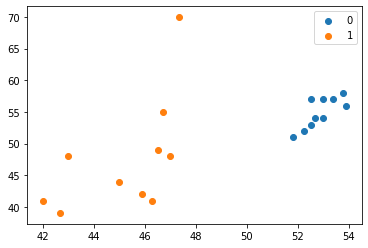

In [168]:
# plot chain code length vs. mean edition distance
zeros = plt.scatter(D0,L0)
ones = plt.scatter(D1,L1)
plt.legend((zeros,ones),("0","1"))


### Elongation(Eclipse fitted)

C:\ProgramData\Anaconda\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\ProgramData\Anaconda\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


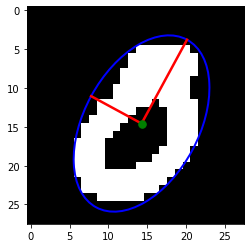

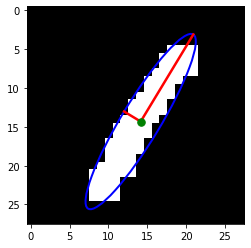

In [27]:
elongation_plot(zeros_im[0])
elongation_plot(ones_im[0])

### TODO: Finialize this function: Use 1D feature or find a second feature?

In [37]:
def cal_major_minor_axis(img):
    label_img = label(img)
    [props] = regionprops(label_img)
#     return [props.major_axis_length/props.minor_axis_length,props.minor_axis_length/props.major_axis_length]
    # replace with 1D feature instead?
    return [props.major_axis_length/props.minor_axis_length]

In [59]:
axis_length_zeros=[]
axis_length_ones=[]

for im0, im1 in zip(zeros_im,ones_im):
    axis_length_zeros.append(cal_major_minor_axis(im0))
    # Perform opening to remove noise in images of 1, particularly in 1_8.png
    el = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    im1 = ndimage.binary_opening(im1,el)
    axis_length_ones.append(cal_major_minor_axis(im1))
    
axis_length_zeros = np.array(axis_length_zeros)
axis_length_ones = np.array(axis_length_ones)


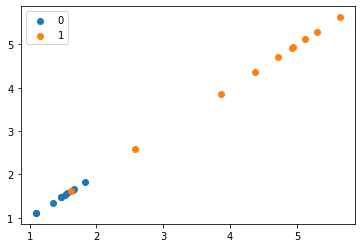

In [60]:
# zeros = plt.scatter(axis_length_zeros[:,0], axis_length_zeros[:,1])
# ones = plt.scatter(axis_length_ones[:,0], axis_length_ones[:,1])

zeros = plt.scatter(axis_length_zeros, axis_length_zeros)
ones = plt.scatter(axis_length_ones, axis_length_ones)
plt.legend((zeros,ones),("0","1"))
plt.show()

### Morphological Skeleton

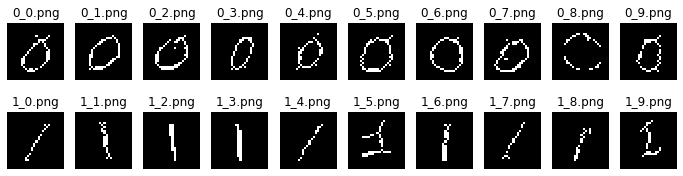

In [62]:
# Skeletonize images
Sr_zeros_im = []
Sr_ones_im = []
for im0, im1 in zip(zeros_im, ones_im):
    skel0 = skeletonize(im0)
    Sr_zeros_im.append(skel0) 
    skel1 = skeletonize(im1)
    Sr_ones_im.append(skel1)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

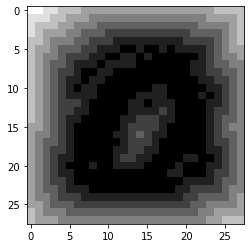

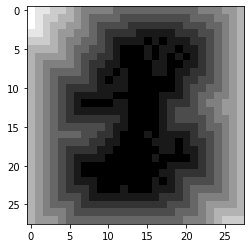

In [65]:
# plot distance maps with mean skeleton
mean_skel0 = np.array(np.mean(Sr_zeros_im,0))
mean_skel1 = np.array(np.mean(Sr_ones_im,0))
mean_skel0[mean_skel0>0] = 1
mean_skel1[mean_skel1>0] = 1

# Chamfer distance map
distance_map_0 = morphology.distance_transform_cdt(1-mean_skel0)
plt.imshow(distance_map_0, cmap ='gray')
plt.show()
distance_map_1 = morphology.distance_transform_cdt(1-mean_skel1)
plt.imshow(distance_map_1, cmap ='gray')

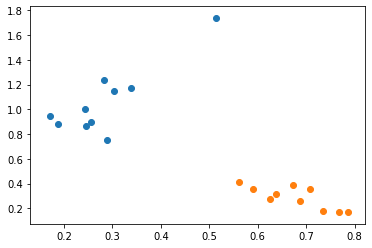

In [123]:
# Calculate image distances
distance_zeros=[]
for im in zeros_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_zeros.append([distance_0,distance_1])
distance_zeros = np.array(distance_zeros)
# print(distance_zeros)
distance_ones=[]
for im in ones_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_ones.append([distance_0,distance_1])
distance_ones = np.array(distance_ones)
# print(distance_ones)

# plot distances from mean skeletons of 0s and 1s
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

### Contours + Distance Map method  
### TODO: Change to mean contour? Currently only the first contour is used to calculate distance map

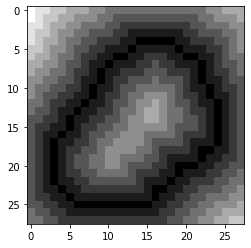

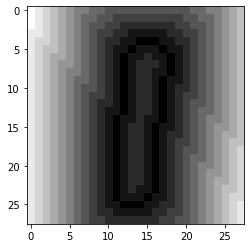

In [69]:
# Contour detection
contours = np.array(measure.find_contours(ones_im[6], 0))[0]
cont_1 = np.zeros_like(ones_im[0])
cont_1[contours[:,0].astype(int),contours[:,1].astype(int)]=1
plt.imshow(cont_1)
contours = np.array(measure.find_contours(zeros_im[7], 0))[0]
cont_0 = np.zeros_like(zeros_im[0])
cont_0[contours[:,0].astype(int),contours[:,1].astype(int)]=1
plt.imshow(cont_0)

# Chamfer distance maps
distance_map_0 = morphology.distance_transform_cdt(1-cont_0)
plt.imshow(distance_map_0, cmap ='gray')
plt.show()
distance_map_1 = morphology.distance_transform_cdt(1-cont_1)
plt.imshow(distance_map_1, cmap ='gray')

In [76]:
# Apply distance maps
distance_zeros=[]
distance_ones=[]

for im0, im1 in zip(zeros_im, ones_im):
    contours0 = np.array(measure.find_contours(im0, 0))[0]
    cont_0 = np.zeros_like(zeros_im[0])
    cont_0[contours0[:,0].astype(int),contours0[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_0))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_0))
    distance_zeros.append([distance_0,distance_1])
    
    contours1 = np.array(measure.find_contours(im1, 0))[0]
    cont_1 = np.zeros_like(ones_im[0])
    cont_1[contours1[:,0].astype(int),contours1[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_1))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_1))
    distance_ones.append([distance_0,distance_1])
    
distance_zeros = np.array(distance_zeros)
distance_ones = np.array(distance_ones)


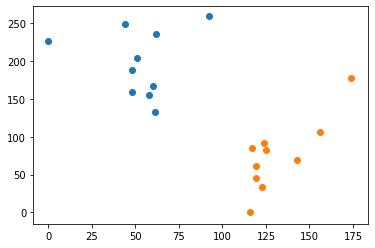

In [77]:
#Plot results
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

## PCA


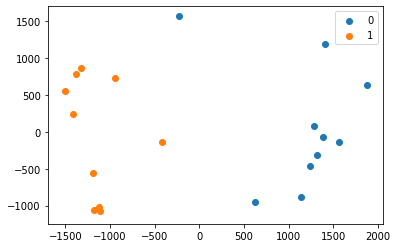

In [78]:
zeros_im_data = zeros_im.reshape(10,-1)
ones_im_data = ones_im.reshape(10,-1)
digits=np.concatenate((zeros_im_data,ones_im_data),axis = 0)

pca = decomposition.PCA(2) 
projected = pca.fit_transform(digits)
plt.scatter(projected[:10,0], projected[:10,1])
plt.scatter(projected[10:,0], projected[10:,1])
plt.legend(["0", "1"])

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

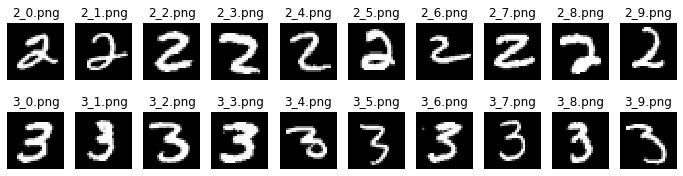

In [115]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

### PCA
Apparently does not work...

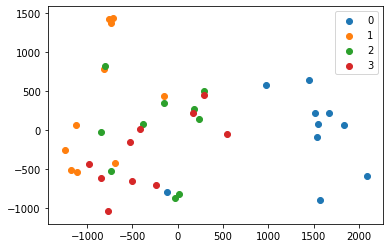

In [85]:
zeros_im_data = zeros_im.reshape(10,-1)
ones_im_data = ones_im.reshape(10,-1)
twos_im_data = twos_im.reshape(10,-1)
threes_im_data = threes_im.reshape(10,-1)
digits=np.concatenate((zeros_im_data,ones_im_data,twos_im_data,threes_im_data),axis = 0)

pca = decomposition.PCA(2) 
projected = pca.fit_transform(digits)
for i in range(4):
    plt.scatter(projected[i*10:(i+1)*10,0],projected[i*10:(i+1)*10,1])

plt.legend(["0", "1", "2", "3"])

### Fourier Descriptors

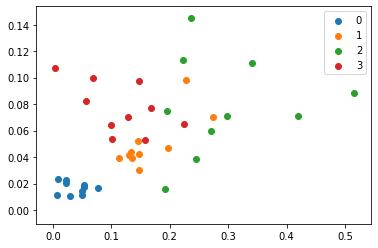

In [101]:
# original images
f1 = 3
f2 = 5
f_div = 1
FD0, FD1 = get_fourier_discriptor(zeros_im, ones_im, f1, f2, f_div)
FD2, FD3 = get_fourier_discriptor(twos_im, threes_im, f1, f2, f_div)
plt.scatter(FD0[:,0], FD0[:,1])
plt.scatter(FD1[:,0], FD1[:,1])
plt.scatter(FD2[:,0], FD2[:,1])
plt.scatter(FD3[:,0], FD3[:,1])
plt.legend(["0","1","2","3"])

### Skeletonize
### TODO: How do we extract two features now if we apply distance map there will be 4 distances for each image?

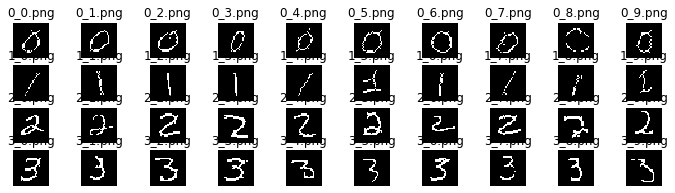

In [116]:
# Skeletonize images
Sr_zeros_im = []
Sr_ones_im = []
Sr_twos_im = []
Sr_threes_im = []
for im0, im1, im2, im3, in zip(zeros_im, ones_im, twos_im, threes_im):
    Sr_zeros_im.append(skeletonize(im0)) 
    Sr_ones_im.append(skeletonize(im1))
    Sr_twos_im.append(skeletonize(im2))
    Sr_threes_im.append(skeletonize(im3))

fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], Sr_twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], Sr_threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [117]:
twos_im[twos_im>0] = 255
threes_im[threes_im>0] = 255

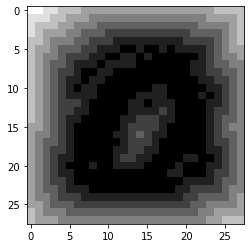

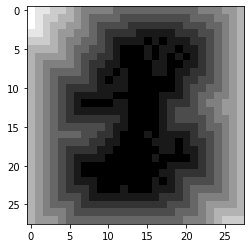

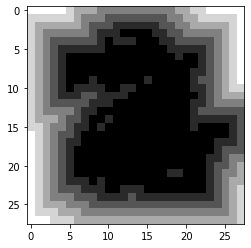

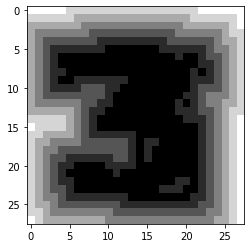

In [105]:
# plot distance maps with mean skeleton
mean_skel0 = np.array(np.mean(Sr_zeros_im,0))
mean_skel1 = np.array(np.mean(Sr_ones_im,0))
mean_skel2 = np.array(np.mean(Sr_twos_im,0))
mean_skel3 = np.array(np.mean(Sr_threes_im,0))

mean_skel0[mean_skel0>0] = 1
mean_skel1[mean_skel1>0] = 1
mean_skel2[mean_skel2>0] = 1
mean_skel3[mean_skel3>0] = 1

# Chamfer distance map
distance_map_0 = morphology.distance_transform_cdt(1-mean_skel0)
plt.imshow(distance_map_0, cmap ='gray')
plt.show()
distance_map_1 = morphology.distance_transform_cdt(1-mean_skel1)
plt.imshow(distance_map_1, cmap ='gray')
plt.show()
distance_map_2 = morphology.distance_transform_cdt(1-mean_skel2)
plt.imshow(distance_map_2, cmap ='gray')
plt.show()
distance_map_3 = morphology.distance_transform_cdt(1-mean_skel3)
plt.imshow(distance_map_3, cmap ='gray')

### Freeman Code

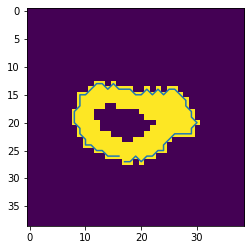

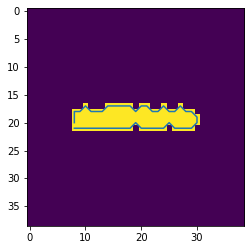

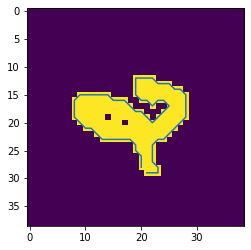

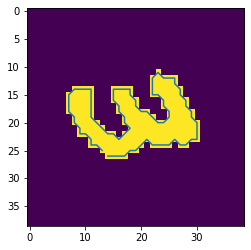

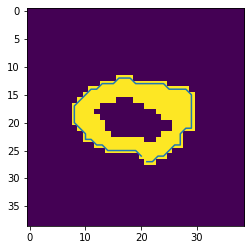

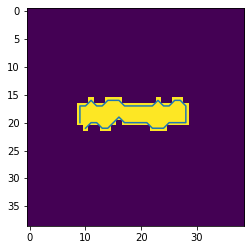

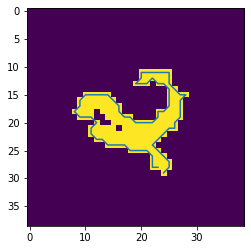

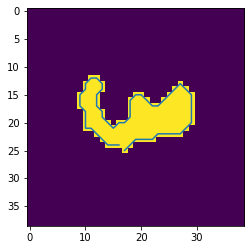

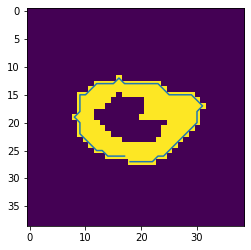

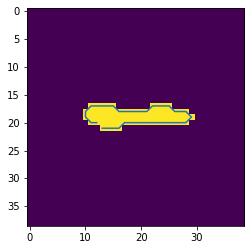

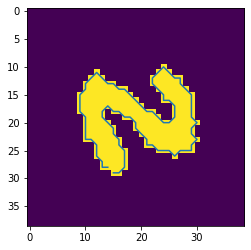

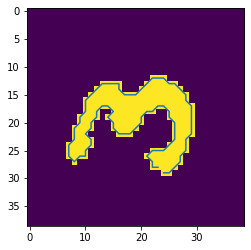

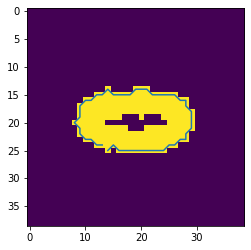

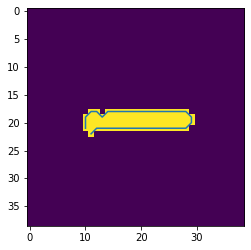

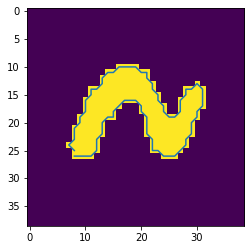

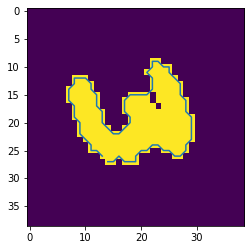

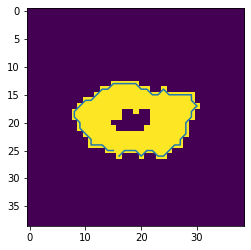

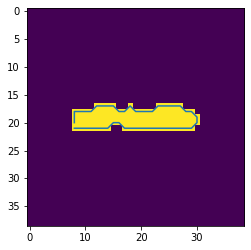

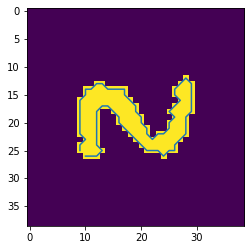

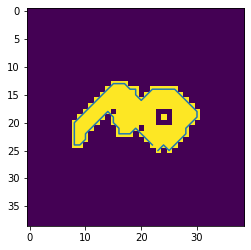

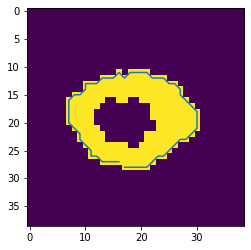

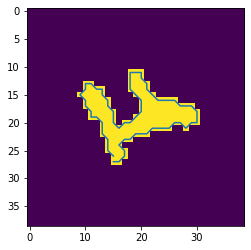

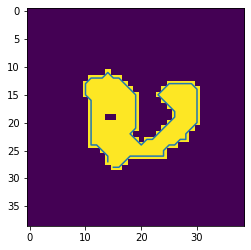

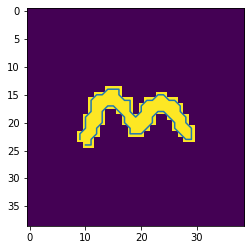

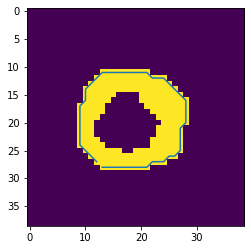

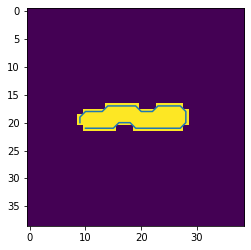

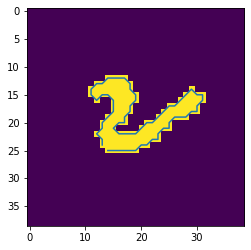

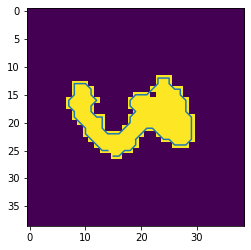

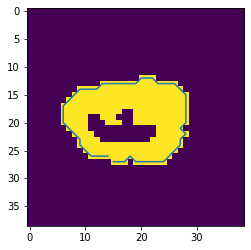

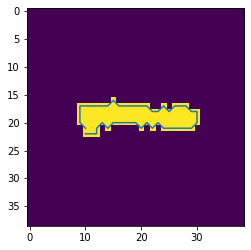

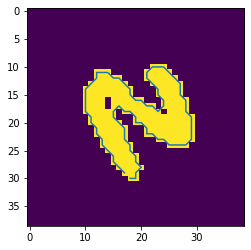

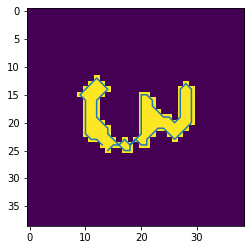

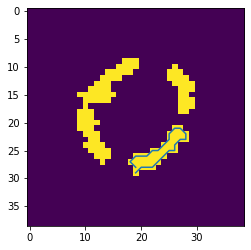

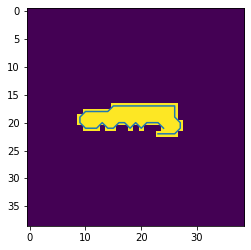

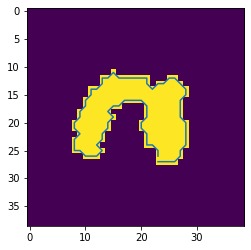

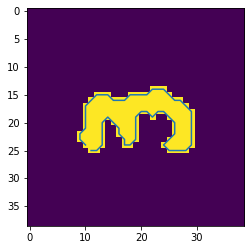

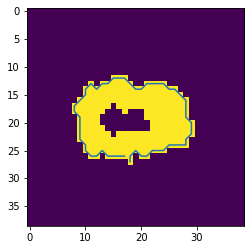

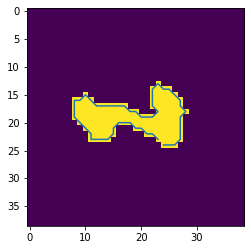

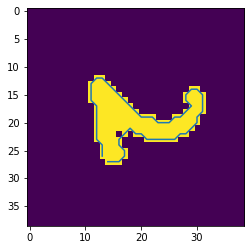

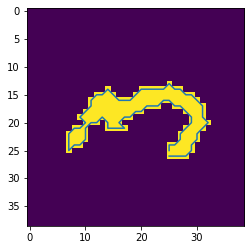

In [163]:
# Calculate chain codes for images and plot results

chain_zeros = []
chain_ones = []
chain_twos = []
chain_threes = []

for img0, img1, img2, img3 in zip(zeros_im, ones_im, twos_im, threes_im):
    # Preprocess images to remove small deteched object pixels that could confuse the chain code calculation function
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    img1 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, element)
    img2 = cv2.morphologyEx(img2, cv2.MORPH_OPEN, element)
    img3 = cv2.morphologyEx(img3, cv2.MORPH_OPEN, element)
    img0 = cv2.morphologyEx(img0, cv2.MORPH_OPEN, element)
    
    # Align orientations
    [props0] = regionprops(img0)
    [props1] = regionprops(img1)
    [props2] = regionprops(img2)
    [props3] = regionprops(img3)

    img0 = rotate(img0, -props0.orientation)
    img1 = rotate(img1, -props1.orientation)
    img2 = rotate(img2, -props2.orientation)
    img3 = rotate(img3, -props3.orientation)
    # Calculate chain codes
    chain_zeros.append(chain_code(img0))
    chain_ones.append(chain_code(img1))
    chain_twos.append(chain_code(img2))
    chain_threes.append(chain_code(img3))
# Combine all chain codes
chains = []
chains.append(chain_zeros)
chains.append(chain_ones)
chains.append(chain_twos)
chains.append(chain_threes)
chains = np.array(chains).reshape(1,-1)

In [164]:
# Calculate chain code edition distances
ED0 = []
ED1 = []
ED2 = []
ED3 = []
L0 = []
L1 = []
L2 = []
L3 = []
D0 = []
D1 =[]
D2 = []
D3 =[]
for c0, c1, c2, c3 in zip(chain_zeros, chain_ones, chain_twos, chain_threes):
    L0.append(len(c0))
    L1.append(len(c1))
    L2.append(len(c2))
    L3.append(len(c3))

    for cref in chains:
        # mean edition distance between each pair
        ED0.append(editDistance(cref, c0))
        ED1.append(editDistance(cref, c1))
        ED2.append(editDistance(cref, c2))
        ED3.append(editDistance(cref, c3))
        
    D0.append(np.mean(ED0))
    D1.append(np.mean(ED1)) 
    D2.append(np.mean(ED2))
    D3.append(np.mean(ED3))

D0 = np.array(D0)
D1 = np.array(D1)
D2 = np.array(D2)
D3 = np.array(D3)

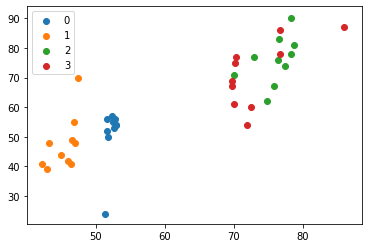

In [165]:
# plot chain code length vs. mean edition distance
zeros = plt.scatter(D0,L0)
ones = plt.scatter(D1,L1)
twos = plt.scatter(D2,L2)
threes = plt.scatter(D3,L3)
plt.legend((zeros,ones,twos,threes),("0","1","2","3"))
